## [Data Science] Image Processing : Exploratory & Modeling
In this poject we will work on a set of image of letters in plenty of differents fronts.
The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labeled examples. Given these sizes, it should be possible to train models quickly on any machine.


You need to go step by step through this notebook, and fill the code in the //TODO. 
Please make sure to explain clearly all your choices. 

In [1]:
# These are all the modules that could be use for this project. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import sys
import tarfile
from IPython.display import display, Image
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
import seaborn as sns
import pandas as pd
from six.moves import cPickle
import random
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
np.random.seed(133)
print(f'Using Python  = {sys.version.split()[0]}')
print(f'Tensorflow    = {tf.__version__}')


Using Python  = 3.7.3
Tensorflow    = 2.0.0


## Step 1 Download data set

In order to save you time we provide this function

In [144]:

url = 'https://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress(count, blockSize, totalSize):
    """
    Simple hook to report the progress of a download. 
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
      
        last_percent_reported = percent
        
def gz_download(filename, expected_bytes, force=False):
    """
    Download a file if not present, and make sure it's the right size.
    """
    dest_filename = os.path.join(data_root, filename)
    if force or not os.path.exists(dest_filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress)
        print('\nDownload Complete!')
    statinfo = os.stat(dest_filename)
  
    if statinfo.st_size == expected_bytes:
        print('Found and verified', dest_filename)
    else:
        raise Exception('Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
    return dest_filename

train_filename = gz_download('notMNIST_large.tar.gz', 247336696)
test_filename = gz_download('notMNIST_small.tar.gz', 8458043)

Found and verified .\notMNIST_large.tar.gz
Found and verified .\notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file. This should give you a set of directories, labeled A through J.

In [155]:
#Cette fonction extrait les fichiers d'un repertoire compressé, les stocke dans un dossier 
#et retourne l'adresse du dossier contenant les fichiers extraits
def tar_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    #my_tar = tarfile.open(filename)
    #my_tar.extractall(root) # specify which folder to extract to
    #my_tar.close()
    data_folders = []
    for dirs in os.walk(root):
        if dirs[2]:
            print(dirs[0])
            data_folders.append(dirs[0])
    return data_folders
  
train_folders = tar_extract(train_filename)
test_folders = tar_extract(test_filename)
#train_folders = train_folders + "\\notMNIST_large"
#test_folders = test_folders + "\\notMNIST_small"

.\notMNIST_large\notMNIST_large
.\notMNIST_large\notMNIST_large\A
.\notMNIST_large\notMNIST_large\B
.\notMNIST_large\notMNIST_large\C
.\notMNIST_large\notMNIST_large\D
.\notMNIST_large\notMNIST_large\E
.\notMNIST_large\notMNIST_large\F
.\notMNIST_large\notMNIST_large\G
.\notMNIST_large\notMNIST_large\H
.\notMNIST_large\notMNIST_large\I
.\notMNIST_large\notMNIST_large\J
.\notMNIST_small\notMNIST_small
.\notMNIST_small\notMNIST_small\A
.\notMNIST_small\notMNIST_small\B
.\notMNIST_small\notMNIST_small\C
.\notMNIST_small\notMNIST_small\D
.\notMNIST_small\notMNIST_small\E
.\notMNIST_small\notMNIST_small\F
.\notMNIST_small\notMNIST_small\G
.\notMNIST_small\notMNIST_small\H
.\notMNIST_small\notMNIST_small\I
.\notMNIST_small\notMNIST_small\J


## Problem 1
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. 

In [156]:
#Dans chaque Dossier correspondant à une lettre (dans le train_dataset), on prend une lettre de façon aléatoire puis on affiche 
#cette lettre

#A noter, les résultats affichés sont cohérents dans l'ensemble mais on peut constater que le dataset contient certaines données
#erronéées, enfait certaines images affichées ne correspondent pas à la lettre à laquelles elles sont attribués
for dirs in os.walk(test_folders[0]):
    if dirs[2]:
        if not any("pickle" in s for s in dirs[2]):
            img = dirs[0] + "\\" + random.choice(dirs[2])
            pil_img = Image(filename=img)
            display(pil_img)



Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. We could merge into a single dataset of manageable size if needed.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.


In [160]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letters(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    except ValueError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            # You may override by setting force=True.
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)

            dataset = load_letters(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    cPickle.dump(dataset, f, cPickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)
    return dataset_names

train_folders.pop(0)
test_folders.pop(0)

train_datasets = pickle(train_folders, 45000)
test_datasets = pickle(test_folders, 1800)

.\notMNIST_large\notMNIST_large\B.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\C.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\D.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\E.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\F.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\G.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\H.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\I.pickle already present - Skipping pickling.
.\notMNIST_large\notMNIST_large\J.pickle already present - Skipping pickling.
.\notMNIST_small\notMNIST_small\A.pickle already present - Skipping pickling.
.\notMNIST_small\notMNIST_small\B.pickle already present - Skipping pickling.
.\notMNIST_small\notMNIST_small\C.pickle already present - Skipping pickling.
.\notMNIST_small\notMNIST_small\D.pickle already present - Skipp

## Problem 2
Verify that the data still looks good. Displaying a sample of the labels and images from the ndarray.

A


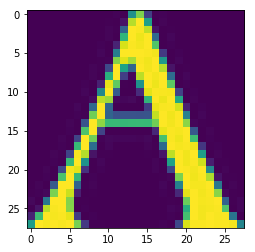

B


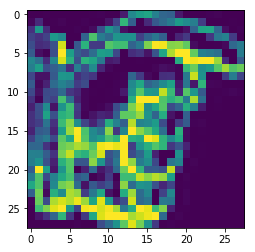

C


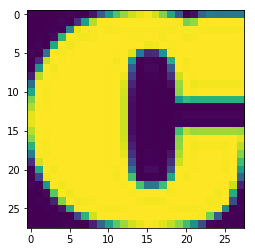

D


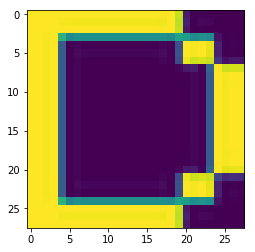

E


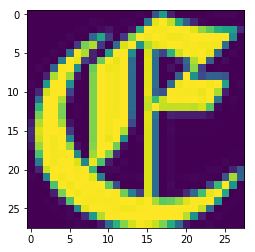

F


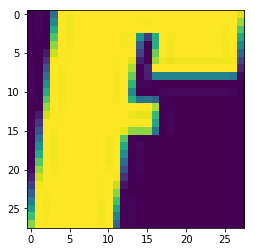

G


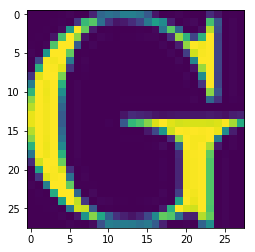

H


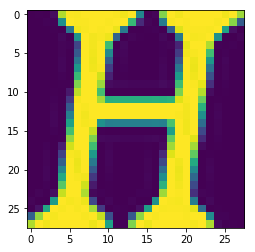

I


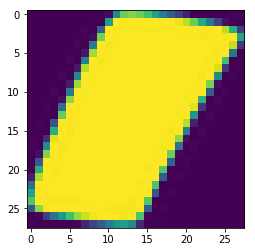

J


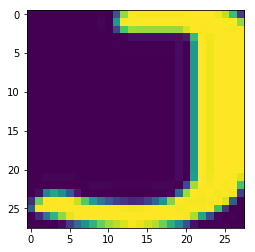

In [7]:
#Afin de vérifier la qualité des données après le opérations réalisés, nous allons à partir des 3D Array reconstituer
#les images et les afficher
alph = ['A','B','C','D','E','F','G','H','I','J']
e=0
for c,fichier in enumerate(train_datasets):
    objects = []
    with (open(fichier, "rb")) as openfile:
        e = cPickle.load(openfile)
        choix = random.choice(e)
        print(alph[c])
        plt.imshow(choix, interpolation='nearest')
        plt.show()
    

## Problem 3
Another check: Verify that the data is balanced across classes. 

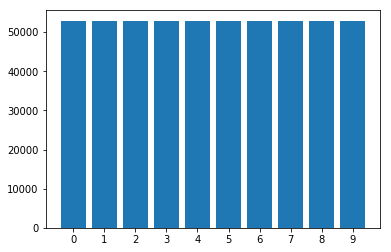

In [15]:
#On recupere depuis les données l'ensemble des labels et le nombre d'occurence de chaque labels
#Dans le graphique ci-dessous, on constate que les labels/classes sont bien réparties dans le dataset
nb_letter = []
e=0
for c,fichier in enumerate(train_datasets):
    objects = []
    with (open(fichier, "rb")) as openfile:
        e = cPickle.load(openfile)
        nb_letter.append(e.shape[0])

df = pd.DataFrame(nb_letter,columns=['Lettre'])

x = df.index.values
y = [e[0] for e in df.values]
plt.bar(x,y)
plt.xticks(x)
plt.show()


Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [10]:
#Cette fonction récupere pour chaque fichier pickle d'un dataset, l'ensemble des images sous formes de données numériques
#Ces données sont séparés, d'un coté un tableau à 3dimensions pour l'image, l'autre est une liste qui contient les lettres 
#présentes sur chaque image
#On a ainsi nos données X, et les labels Y en sortie
def data_merge(datasets):
    values = np.array([])
    labels = []
    for c,fichier in enumerate(datasets):
        with (open(fichier, "rb")) as openfile:
            e = cPickle.load(openfile)
            label = e.shape[0] * [c] #Une liste label de taille égale au nombres d'images est crée, avec un seul label utilisé
            labels = labels + label
            if (values.size == 0):
                values = e #Lors de la première itération, pour permettre la concaténation de tous les 3D array
            else :
                values = np.concatenate((values, e), axis = 0)
    return values,np.array(labels)

In [16]:
# For example
# Je n'ai pas utilisé ce paramètre pour pouvoir directement et rapidement manipuler la taille des datasets utilisés lors
# de l'entrainement des modèles.
train_size = 200000
valid_size = 10000
test_size = 10000

#On utilise la fonction précédente pour fusioner les données contenue dans chaque fichier d'un dataset
#Pour les données issues du dataset test, on les sépare en 2 dataset un pour la validation, un pour le test

train_dataset, train_labels = data_merge(train_datasets)
X,Y = data_merge(test_datasets)
test_dataset, valid_dataset, test_labels, valid_labels = train_test_split(X, Y, test_size = 0.5, random_state=42)


print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (529114, 28, 28) (529114,)
Validation: (9362, 28, 28) (9362,)
Testing: (9362, 28, 28) (9362,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.



In [17]:
def randomize(dataset, labels):
    permutation = np.random.permutation(labels.shape[0])
    shuffled_dataset = dataset[permutation,:,:]
    shuffled_labels = labels[permutation]
    return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

## Problem 4
Convince yourself that the data is still good after shuffling!



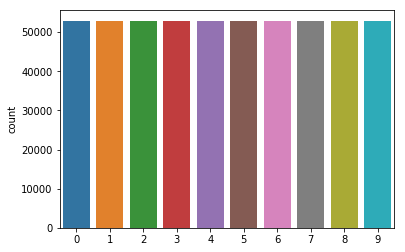

In [18]:
sns.countplot(train_labels)

#### En l'occurence apres l'utilisation de la méthode Shuffle, les données sont bien réparties dans chaque classe (Lettre)

Save the data for later reuse:



In [20]:
#On conserve toutes les données dans un tuple qu'on va sauvegarder au format pickle
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

data_to_save = (train_dataset, train_labels,test_dataset, test_labels, valid_dataset, valid_labels)

try:
    print(pickle_file)
    with open(pickle_file, 'wb') as f:
        cPickle.dump(data_to_save, f, cPickle.HIGHEST_PROTOCOL)

except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)

.\notMNIST.pickle


In [27]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 1720211734
1.6020720209926367


   #      -----------  Arrivé ici au bout de 3 Heures  -----------

## Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set. Measure how much overlap there is between training, validation and test samples.

Optional questions:

What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent questions.

In [72]:
#unique, counts = np.unique(train_dataset, return_counts=True)
#print(counts)
train_unique = len(np.unique(train_dataset, axis=0))
test_unique  = len(np.unique(test_dataset,  axis=0))
valid_unique = len(np.unique(valid_dataset, axis=0))
nb_duplicate_train = len(train_dataset)-train_unique
nb_duplicate_test  = len(test_dataset) -test_unique
nb_duplicate_valid = len(valid_dataset)-valid_unique

In [100]:
# Afin de détecter les duplicats entre les dataset, nous utilison la fonction intersect1D de numpy qui fournit la liste des
# duplicats c'est à dire, les images qui sont présentes dans les 2 datasets indiqués en paramètre.
# Seulement cette fonction marche seulement avec des listes à 1 Dimension, nous allons donc transformer nos 3D Array afin
# qu'elles soient compatibles avec la fonction intersect1D.
def duplicats(A,B):
    A = A.reshape(len(A),-1)
    B = B.reshape(len(B),-1)
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
       'formats':ncols * [A.dtype]}

    C = np.intersect1d(A.view(dtype), B.view(dtype))

    # This last bit is optional if you're okay with "C" being a structured array...
    C = C.view(A.dtype).reshape(-1, ncols)
    return C

En complément de la fonction duplicats, j'ai pu trouvé une librairie python proposant une fonction réalisant la même tache,
il s'agit de la librairie numpy_indexed avec la fonction intersection() qui prend en paramètres des 3D array.

In [105]:
import glob, os
import numpy_indexed as npi

print("Duplicats dans le dataset TRAIN :",nb_duplicate_train)
print("Duplicats dans le dataset TEST :" ,nb_duplicate_test)
print("Duplicats dans le dataset VALID :",nb_duplicate_valid)

print("Duplicats entre les datasets TRAIN et TEST :",len(duplicats(train_dataset,test_dataset)),len(npi.intersection(train_dataset,test_dataset)))
print("Duplicats entre les datasets TRAIN et VALID:",len(duplicats(train_dataset,valid_dataset)),len(npi.intersection(train_dataset,valid_dataset)))

# Should render something like
#Duplicates inside training set:  ZZZZ
#Duplicates between training and validation:  ZZZZ
#Duplicates between training and test:  ZZZZ

Duplicats dans le dataset TRAIN : 67168
Duplicats dans le dataset TEST : 206
Duplicats dans le dataset VALID : 169
Duplicats entre les datasets TRAIN et TEST : 2307 2307
Duplicats entre les datasets TRAIN et VALID: 2347 2347


## Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

In [106]:
from sklearn.linear_model import LogisticRegression

nsamples, nx, ny = train_dataset.shape
d2_train_dataset = train_dataset.reshape((nsamples,nx*ny))

lr100 = LogisticRegression(multi_class='multinomial',solver='saga')
lr100.fit(d2_train_dataset[:100],train_labels[:100] )
lr500 = LogisticRegression(multi_class='multinomial',solver='saga')
lr500.fit(d2_train_dataset[:500],train_labels[:500] )
lr1000 = LogisticRegression(multi_class='multinomial',solver='saga')
lr1000.fit(d2_train_dataset[:1000],train_labels[:1000] )
lr5000 = LogisticRegression(multi_class='multinomial',solver='saga')
lr5000.fit(d2_train_dataset[:5000],train_labels[:5000] )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
print("Score of Logistic Regression with 100   samples :",lr100.score(d2_train_dataset,train_labels))
print("Score of Logistic Regression with 500   samples :",lr500.score(d2_train_dataset,train_labels))
print("Score of Logistic Regression with 1000  samples :",lr1000.score(d2_train_dataset,train_labels))
print("Score of Logistic Regression with 10000 samples :",lr5000.score(d2_train_dataset,train_labels))

Score of Logistic Regression with 100   samples : 0.6639816750265538
Score of Logistic Regression with 500   samples : 0.743798122899791
Score of Logistic Regression with 1000  samples : 0.7647728088842858
Score of Logistic Regression with 10000 samples : 0.7735384057121906


In [112]:
test_nsamples, test_nx, test_ny = test_dataset.shape
d2_test_dataset = test_dataset.reshape((test_nsamples,test_nx*test_ny))

def prediction_lettre(i=0):
    img_original = test_dataset[i]
    img_to_predict = d2_test_dataset[i]
    ind_lettre = lr5000.predict(img_to_predict.reshape(1, -1))[0]
    print("Lettre prédite :",alph[ind_lettre])
    print("Lettre à prédire :")
    plt.imshow(img_original, interpolation='nearest',cmap='gray')
    plt.show()

Lettre prédite : I
Lettre à prédire :


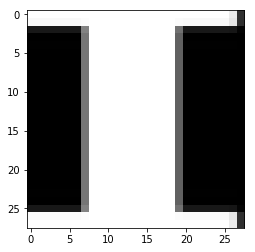

In [113]:
prediction_lettre(866)

## Problem 7
Going on step deeper. 
Please propose a model of your choice.
If you run out of time, you do not have to implement the full code, but explain the steps you need to implement and every parameter choice you make.

We first need to reformat the data

Reformat into a shape that's more adapted to the models we're going to train:

 - data as a flat matrix,
 - labels as float 1-hot encodings.

# Utilisation d'un modèle de réseaux de Neurones

### Ici nous utilisions un type de réseaux de neurones adapté aux types de données, en l'occurence des images.
### Il s'agit du modèle CNN, un réseau de neurones convolutif.

#### 1. Importation des librairies

In [114]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


Using TensorFlow backend.


#### 2. Configuration du modèle

S'agissant d'un usage pour catégoriser des images, la fonction d'activation est une softmax, les labels seront transformés en catégorie ( un vecteur de taille égale aux nombres de labels possibles).

Le dropout va permettre de réduire l'overfitting en désactivant aléatoirement certaines neurones d'une couche.

In [115]:
model = Sequential()
#
model.add(Conv2D(filters = 8, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
#
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
# fully connected

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

You can choose a simple multinomial logistic regression using simple gradient descent, or any other multi layer version. Just don't  overengineer and make sure that this model improves your validation / test accuracy from previous problems.

#### 3.Augmentation des données :
Nous realisions de l'augmentation des données, par exemple une image aura une copie avec une rotation (un angle assez faible étant donné qu'il s'agit de lettres), ou un faible zoom (étant donné la qualité/résolution assez basse des images un zoom élévé ne serait pas approprié)

In [116]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  
        vertical_flip=False)  


datagen.fit(train_dataset.reshape(-1,28,28,1)[:1000])

In [118]:
X_reshape = train_dataset.reshape(-1,28,28,1)
V_reshape = valid_dataset.reshape(-1,28,28,1)
Y_one_hot = to_categorical(train_labels)
V_one_hot = to_categorical(valid_labels)

#### 4.Paramétrage/Optimisation du modèle

In [119]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
batch_size = 250

#### 5. Entrainement du modèle

In [123]:
mod = model.fit_generator(datagen.flow(X_reshape[:40000],Y_one_hot[:40000], batch_size=batch_size),
                    epochs = 15, validation_data = (V_reshape[:2000],V_one_hot[:2000]), steps_per_epoch=X_reshape[:40000].shape[0] // batch_size)

Epoch 1/15
160/160 [==============================] - 12s 76ms/step - loss: 0.5314 - accuracy: 0.8436 - val_loss: 0.2100 - val_accuracy: 0.9420
Epoch 2/15
160/160 [==============================] - 12s 76ms/step - loss: 0.5158 - accuracy: 0.8445 - val_loss: 0.2058 - val_accuracy: 0.9425
Epoch 3/15
160/160 [==============================] - 12s 75ms/step - loss: 0.5100 - accuracy: 0.8492 - val_loss: 0.2029 - val_accuracy: 0.9385
Epoch 4/15
160/160 [==============================] - 12s 76ms/step - loss: 0.4998 - accuracy: 0.8498 - val_loss: 0.1960 - val_accuracy: 0.9435
Epoch 5/15
160/160 [==============================] - 12s 77ms/step - loss: 0.4946 - accuracy: 0.8526 - val_loss: 0.1936 - val_accuracy: 0.9425
Epoch 6/15
160/160 [==============================] - 13s 78ms/step - loss: 0.4857 - accuracy: 0.8536 - val_loss: 0.1871 - val_accuracy: 0.9465
Epoch 7/15
160/160 [==============================] - 12s 77ms/step - loss: 0.4842 - accuracy: 0.8557 - val_loss: 0.1852 - val_accuracy:

#### 6. Analyse des performances du modèle

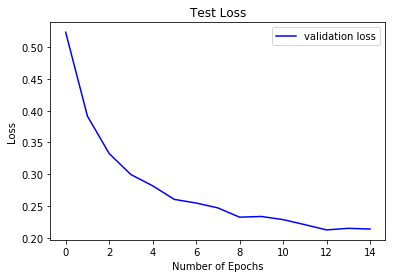

In [121]:
plt.plot(mod.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

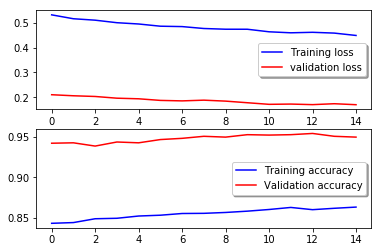

In [128]:
fig, ax = plt.subplots(2,1)
ax[0].plot(mod.history['loss'], color='b', label="Training loss")
ax[0].plot(mod.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(mod.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(mod.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)